In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

In [13]:
# model import
from model.resnet import resnet18

In [120]:
import matplotlib.pyplot as plt

In [80]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [2]:
x = torch.arange(10)

In [5]:
torch.randperm(10)

tensor([0, 3, 7, 4, 2, 6, 5, 8, 9, 1])

In [6]:
data = torch.randn((5, 5))

In [8]:
noise = torch.randn(1)

In [9]:
noise

tensor([-0.2980])

In [232]:
model = resnet18(num_classes=20).eval()

In [233]:
img_dataset = ImageFolder('./data/train_phase1')

In [234]:
x = ToTensor()(img_dataset[0][0]).unsqueeze(0)

In [479]:
def pgd_window_attack(model, x, y, window_size=(32, 32), n_iter=10, step_size=0.03):
    x = x.clone()
    # set the model grad false
    for p in model.parameters():
        p.requires_grad = False
    
    x.requires_grad = False
    
    b, c, h, w = x.shape
    
    cols = torch.arange(window_size[0]) + torch.randint(h-window_size[0], (1,))
    rows = torch.arange(window_size[1]) + torch.randint(w-window_size[1], (1,))
    
    cols, rows = torch.meshgrid(cols, rows)
    
    cols = cols.reshape(-1)
    rows = rows.reshape(-1)
    
    noise = torch.randn((b, c, window_size[0] * window_size[1])) * step_size

    noise.requires_grad_()
    for i in range(n_iter):
        # add up the noise
        x = x.detach()
        
        x[:, :, cols, rows] = noise

        loss_fn = nn.CrossEntropyLoss()

        loss = loss_fn(model(x), y)

        loss.backward()

        noise_grad = noise.grad.data
    
        noise.data = noise.data + step_size * torch.sign(noise_grad)
    
    x[:, :, cols, rows] = noise
    
    x = torch.clip(x, 0, 1)

    for p in model.parameters():
        p.requires_grad = True
        
    return x.detach()

In [480]:
def pgd_pixels_attack(model, x, y, nums, n_iter=10, step_size=0.07):

    x = x.clone()
    # set the model grad false
    for p in model.parameters():
        p.requires_grad = False
    
    x.requires_grad = False
    
    b, c, h, w = x.shape
    
    cols = torch.randint(h, (nums,))
    rows = torch.randint(w, (nums,))
    
    noise = torch.randn((b, c, nums)) * step_size

    noise.requires_grad_()
    
    for i in range(n_iter):
        x = x.detach()
        # add up the noise
        x[:, :, cols, rows] = noise

        loss_fn = nn.CrossEntropyLoss()

        loss = loss_fn(model(x), y)

        loss.backward()

        noise_grad = noise.grad.data
    
        noise.data = noise.data + step_size * torch.sign(noise_grad)
    
    x[:, :, cols, rows] = noise
    
    x = torch.clip(x, 0, 1)

    for p in model.parameters():
        p.requires_grad = True
        
    return x.detach()

In [481]:
def pgd_lines_attack(model, x, y, nums, direction='vertical', n_iter=10, step_size=0.07):
    x = x.clone()
    # set the model grad false
    for p in model.parameters():
        p.requires_grad = False
    
    x.requires_grad = False
    
    b, c, h, w = x.shape
    
    if direction == 'vertical':
        cols = torch.randperm(h)[:nums]
        rows = torch.arange(w)
        noise = torch.randn((b, c, nums * w)) * step_size
    else:
        cols = torch.arange(h)
        rows = torch.randperm(w)[:nums]
        noise = torch.randn((b, c, nums * h)) * step_size
    
    cols, rows = torch.meshgrid(cols, rows, indexing='ij')
    
    cols = cols.reshape(-1)
    rows = rows.reshape(-1)
    noise.requires_grad_()
    
    for i in range(n_iter):
        x = x.detach()
        
        # add up the noise
        x[:, :, cols, rows] = noise

        loss_fn = nn.CrossEntropyLoss()

        loss = loss_fn(model(x), y)

        loss.backward()

        noise_grad = noise.grad.data

        noise.data = noise.data + step_size * torch.sign(noise_grad)
        
        noise.grad.data.zero_()

    
    x[:, :, cols, rows] = noise
    
    x = torch.clip(x, 0, 1)

    for p in model.parameters():
        p.requires_grad = True
        
    return x.detach()

In [482]:
def fgsm_lines_attack(model, x, y, nums, epsilon=0.5, direction='vertical'):
    x = x.clone()
    # set the model grad false
    for p in model.parameters():
        p.requires_grad = False
    
    x.requires_grad = False
    
    b, c, h, w = x.shape
    
    if direction == 'vertical':
        cols = torch.randperm(h)[:nums]
        rows = torch.arange(w)
        noise = torch.randn((b, c, nums * w)) * epsilon
    else:
        cols = torch.arange(h)
        rows = torch.randperm(w)[:nums]
        noise = torch.randn((b, c, nums * h)) * epsilon
    
    cols, rows = torch.meshgrid(cols, rows, indexing='ij')
    
    cols = cols.reshape(-1)
    rows = rows.reshape(-1)
    
    

    noise.requires_grad_()
    
    # add up the noise
    x[:, :, cols, rows] = noise

    loss_fn = nn.CrossEntropyLoss()
    
    loss = loss_fn(model(x), y)
    
    loss.backward()
    
    noise_grad = noise.grad.data

    noise.data += epsilon * torch.sign(noise_grad)
    
    x[:, :, cols, rows] = noise
    
    x = torch.clip(x, 0, 1)

    for p in model.parameters():
        p.requires_grad = True
        
    return x.detach()

In [483]:
def fgsm_pixels_attack(model, x, y, nums=20, epsilon=0.5):
    x = x.clone()
    # set the model grad false
    for p in model.parameters():
        p.requires_grad = False
    
    x.requires_grad = False
    
    b, c, h, w = x.shape
    
    cols = torch.randint(h, (nums,))
    rows = torch.randint(w, (nums,))
    
    noise = torch.randn((b, c, nums)) * epsilon

    noise.requires_grad_()
    
    # add up the noise
    x[:, :, cols, rows] = noise

    loss_fn = nn.CrossEntropyLoss()
    
    loss = loss_fn(model(x), y)
    
    loss.backward()
    
    noise_grad = noise.grad.data
#     x.data[:, :, idxs, :] += epsilon * torch.sign(x_grad.data)[:, :, idxs, :]
    noise.data += epsilon * torch.sign(noise_grad)
    
    x[:, :, cols, rows] = noise
    
    x = torch.clip(x, 0, 1)

    for p in model.parameters():
        p.requires_grad = True
        
    return x.detach()

In [484]:
def fgsm_window_attack(model, x, y, window_size=(32, 32), epsilon=0.3):
    x = x.clone()
    # set the model grad false
    for p in model.parameters():
        p.requires_grad = False
    
    x.requires_grad = False
    
    b, c, h, w = x.shape
    
    cols = torch.arange(window_size[0]) + torch.randint(h-window_size[0], (1,))
    rows = torch.arange(window_size[1]) + torch.randint(w-window_size[1], (1,))
    
    cols, rows = torch.meshgrid(cols, rows)
    
    cols = cols.reshape(-1)
    rows = rows.reshape(-1)
    
    noise = torch.randn((b, c, window_size[0] * window_size[1])) * epsilon

    noise.requires_grad_()
    
    # add up the noise
    x[:, :, cols, rows] = noise

    loss_fn = nn.CrossEntropyLoss()
    
    loss = loss_fn(model(x), y)
    
    loss.backward()
    
    noise_grad = noise.grad.data
#     x.data[:, :, idxs, :] += epsilon * torch.sign(x_grad.data)[:, :, idxs, :]
    noise.data += epsilon * torch.sign(noise_grad)
    
    x[:, :, cols, rows] = noise
    
    x = torch.clip(x, 0, 1)

    for p in model.parameters():
        p.requires_grad = True
        
    return x.detach()

In [485]:
a = torch.arange(3)
b = torch.arange(2)

In [486]:
grid = torch.meshgrid(a, b, indexing='ij')

In [487]:
grid

(tensor([[0, 0],
         [1, 1],
         [2, 2]]),
 tensor([[0, 1],
         [0, 1],
         [0, 1]]))

In [488]:
y = torch.randint(20, (1, ))

In [510]:
y

tensor([2])

In [511]:
x_adv = pgd_window_attack(model, x, y, (32, 32), 90, 0.01)

In [512]:
torch.sum(torch.abs(x_adv - x))

tensor(1352.2673)

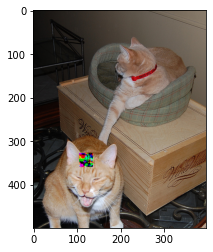

In [513]:
plt.imshow(x_adv.squeeze(0).permute(1, 2, 0).numpy())

In [514]:
model(x_adv)

tensor([[-0.1618, -0.0083, -0.0273,  0.1753,  0.2114,  0.1193, -0.0876,  0.0099,
          0.0324,  0.1679,  0.2685,  0.0802, -0.1104, -0.2058, -0.1520,  0.1854,
          0.0808,  0.0471,  0.1964,  0.3827]], grad_fn=<AddmmBackward0>)

In [515]:
model(x)

tensor([[-0.1627, -0.0074, -0.0250,  0.1754,  0.2119,  0.1201, -0.0881,  0.0104,
          0.0312,  0.1683,  0.2687,  0.0797, -0.1106, -0.2061, -0.1511,  0.1863,
          0.0809,  0.0469,  0.1974,  0.3827]], grad_fn=<AddmmBackward0>)

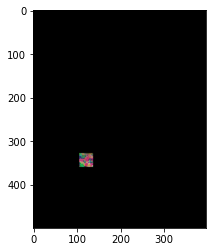

In [516]:
plt.imshow((x-x_adv).abs().squeeze(0).permute(1, 2, 0).numpy())

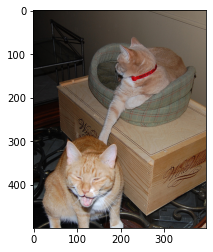

In [517]:
plt.imshow(x.squeeze(0).permute(1, 2, 0).numpy())

In [496]:
def pgd_inf_attack(model, x, y, steps=10, step_size=0.002, epsilon=0.05):
    model.eval()
    x = x.detach()

    x.requires_grad = False
    kl_loss = nn.KLDivLoss(reduction='sum')
    x_adv = x.detach().data + torch.randn_like(x) * 0.001
    y_target = model(x.detach())
    y_target = torch.softmax(y_target, dim=1).detach()
   
    for i in range(steps):
        x_adv.requires_grad_()

        y_pred = torch.log_softmax(model(x_adv), dim=1)
        loss = kl_loss(y_pred, y_target)
        loss.backward()

        x_adv.data += step_size * torch.sign(x_adv.grad.data)
        x_adv.grad.data.zero_()

        with torch.no_grad():
            x_adv = torch.clip(x_adv, x - epsilon, x + epsilon)
            x_adv = torch.clip(x_adv, 0, 1)
           
    x_adv.requires_grad_(False).detach()
    model.train()
    return x_adv